<a href="https://colab.research.google.com/github/anyuanay/dsr_n2c2/blob/main/notebooks/NER_sklearn_crfsuite_example_CoNLL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NER Using sklearn crfsuite
Link: https://sklearn-crfsuite.readthedocs.io/en/latest/tutorial.html

Reference: https://medium.com/data-science-in-your-pocket/named-entity-recognition-ner-using-conditional-random-fields-in-nlp-3660df22e95c

## BIO Annotation for NER
Tags of entities are encoded in a BIO-annotation scheme. Each entity is labeled with a B or an I to detect multi-word entities, where B denotes the beginning of an entity and I denote the inside of an entity. O denotes all other words which are not named entities.

# CRF Basics
Given a sequence $x$, we predict the sequence $y$ of labels for $x$, as follows, where the labels are drawn from a set $\{l_1, l_2, ..., l_k\}$:

$p_\theta(y|x) = \frac{\exp(\sum_{j}w_{j}F_{j}(x,y))}{\sum_{y^{'}}(\exp(\sum_{j}w_{j}F_{j}(x,y^{'})))}$

$Fⱼ(x,y)$ = summation of values of a feature function for all words. The numerator can be written as:

$\exp(\sum_{j}w_{j}\sum_{i}feature\_function_{j}(x,y_{i}, y_{i-1}, i))$

- The inner summation goes from $i=1$ to $i=length$ of a sentence. Hence we are summating the value of any feature function for all words of the sentence

If we have a sentence ‘Ram is cool’, the inner summation will add values of the output of the jᵗʰ feature function for all 3 words of the sentence

- The outer summation goes from $j=1$ to the total number of feature functions. It is doing something like this: $\sum_{j}w_{j}\sum_{i}feature\_function_{j}(x,y_{i}, y_{i-1}, i))$
- $w_{j}$ refers to the weight assigned to a $feature\_function_{j}$.

The denominator sums over all possible sequences.

## Feature Functions

- embedding of word $w_{i}$
- embedding of neighboring words
- part of speech of word $w_i$
- part of speech of neighboring words
- presence in a gazetteer
- prefix of word $w_i$ and neighboring words
- suffix of word $w_i$ and neighboring words
- case of word $w_i$ and neighboring words
- shape of word $w_i$ and neighboring words
- and lot more...


# Let's Code

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [3]:
!pip install -U 'scikit-learn<0.24'

     |████████████████████████████████| 6.8 MB 8.8 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imbalanced-learn 0.8.1 requires scikit-learn>=0.24, but you have scikit-learn 0.23.2 which is incompatible.


In [4]:
!pip install sklearn-crfsuite

In [5]:
from itertools import chain

import nltk
import sklearn
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

## Let's use CoNLL 2002 data to build a NER system

CoNLL2002 corpus is available in NLTK. We use Spanish data.

In [6]:
nltk.download('conll2002')

[nltk_data] Downloading package conll2002 to /root/nltk_data...
[nltk_data]   Package conll2002 is already up-to-date!


True

In [7]:
nltk.corpus.conll2002.fileids()

['esp.testa', 'esp.testb', 'esp.train', 'ned.testa', 'ned.testb', 'ned.train']

In [8]:
%%time
train_sents = list(nltk.corpus.conll2002.iob_sents('esp.train'))
test_sents = list(nltk.corpus.conll2002.iob_sents('esp.testb'))

CPU times: user 2.02 s, sys: 124 ms, total: 2.14 s
Wall time: 2.13 s


In [9]:
train_sents[0]

[('Melbourne', 'NP', 'B-LOC'),
 ('(', 'Fpa', 'O'),
 ('Australia', 'NP', 'B-LOC'),
 (')', 'Fpt', 'O'),
 (',', 'Fc', 'O'),
 ('25', 'Z', 'O'),
 ('may', 'NC', 'O'),
 ('(', 'Fpa', 'O'),
 ('EFE', 'NC', 'B-ORG'),
 (')', 'Fpt', 'O'),
 ('.', 'Fp', 'O')]

## Features

Next, define some features. In this example we use word identity, word suffix, word shape and word POS tag; also, some information from nearby words is used. 

This makes a simple baseline, but you certainly can add and remove some features to get (much?) better results - experiment with it.

sklearn-crfsuite (and python-crfsuite) supports several feature formats; here we use feature dicts.

In [10]:
def word2features(sent, i):
    word = sent[i][0] # assume tuples in a sentence (word, pos, tag)
    postag = sent[i][1] # the second element in the tuple is pos tag
    
    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:], # last 3 chars
        'word[-2:]': word[-2:], # last 2 chars
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2], # the first 2 chars in a pos tag        
    }
    if i > 0:
        word1 = sent[i-1][0] # the previous word
        postag1 = sent[i-1][1] # the previous pos tag
        features.update({ # add new features to the words except for the first one
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True # a feature for the first word
        
    if i < len(sent)-1: # words before the last word
        word1 = sent[i+1][0] # the next word
        postag1 = sent[i+1][1] # the next pos
        features.update({ # add features for words except for the last word
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True # a feature for the last word
                
    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]

This is what word2features extracts:

In [11]:
train_sents[0][0]

('Melbourne', 'NP', 'B-LOC')

In [12]:
sent2features(train_sents[0])[0]

{'+1:postag': 'Fpa',
 '+1:postag[:2]': 'Fp',
 '+1:word.istitle()': False,
 '+1:word.isupper()': False,
 '+1:word.lower()': '(',
 'BOS': True,
 'bias': 1.0,
 'postag': 'NP',
 'postag[:2]': 'NP',
 'word.isdigit()': False,
 'word.istitle()': True,
 'word.isupper()': False,
 'word.lower()': 'melbourne',
 'word[-2:]': 'ne',
 'word[-3:]': 'rne'}

Extract features from the data:

In [13]:
%%time
X_train = [sent2features(s) for s in train_sents]
y_train = [sent2labels(s) for s in train_sents]

X_test = [sent2features(s) for s in test_sents]
y_test = [sent2labels(s) for s in test_sents]

CPU times: user 1.11 s, sys: 193 ms, total: 1.3 s
Wall time: 1.31 s


In [14]:
len(X_train), len(y_train)

(8323, 8323)

In [15]:
X_train[0:1]

[[{'+1:postag': 'Fpa',
   '+1:postag[:2]': 'Fp',
   '+1:word.istitle()': False,
   '+1:word.isupper()': False,
   '+1:word.lower()': '(',
   'BOS': True,
   'bias': 1.0,
   'postag': 'NP',
   'postag[:2]': 'NP',
   'word.isdigit()': False,
   'word.istitle()': True,
   'word.isupper()': False,
   'word.lower()': 'melbourne',
   'word[-2:]': 'ne',
   'word[-3:]': 'rne'},
  {'+1:postag': 'NP',
   '+1:postag[:2]': 'NP',
   '+1:word.istitle()': True,
   '+1:word.isupper()': False,
   '+1:word.lower()': 'australia',
   '-1:postag': 'NP',
   '-1:postag[:2]': 'NP',
   '-1:word.istitle()': True,
   '-1:word.isupper()': False,
   '-1:word.lower()': 'melbourne',
   'bias': 1.0,
   'postag': 'Fpa',
   'postag[:2]': 'Fp',
   'word.isdigit()': False,
   'word.istitle()': False,
   'word.isupper()': False,
   'word.lower()': '(',
   'word[-2:]': '(',
   'word[-3:]': '('},
  {'+1:postag': 'Fpt',
   '+1:postag[:2]': 'Fp',
   '+1:word.istitle()': False,
   '+1:word.isupper()': False,
   '+1:word.lower(

In [16]:
y_train[0:1]

[['B-LOC', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'O', 'O']]

## Training

To see all possible CRF parameters check its docstring. Here we are useing L-BFGS training algorithm (it is default) with Elastic Net (L1 + L2) regularization.

In [17]:
%%time
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs', 
    c1=0.1, 
    c2=0.1, 
    max_iterations=100, 
    all_possible_transitions=True
)
crf.fit(X_train, y_train)

CPU times: user 43.1 s, sys: 263 ms, total: 43.4 s
Wall time: 43.2 s


## Evaluation

There is much more O entities in data set, but we're more interested in other entities. To account for this we'll use averaged F1 score computed for all labels except for O. ``sklearn-crfsuite.metrics`` package provides some useful metrics for sequence classification task, including this one.

In [18]:
labels = list(crf.classes_)
labels.remove('O')
labels

['B-LOC', 'B-ORG', 'B-PER', 'I-PER', 'B-MISC', 'I-ORG', 'I-LOC', 'I-MISC']

In [19]:
y_pred = crf.predict(X_test)
metrics.flat_f1_score(y_test, y_pred, 
                      average='weighted', labels=labels)

0.7964686316443963

Inspect per-class results in more detail:

In [20]:
# group B and I results
sorted_labels = sorted(
    labels, 
    key=lambda name: (name[1:], name[0])
)

In [21]:
from sklearn.metrics import classification_report

In [22]:
y_test_flatten = [lab for sent in y_test for lab in sent]
y_pred_flatten = [lab for sent in y_pred for lab in sent]

In [23]:
print(classification_report(
    y_test_flatten, y_pred_flatten, labels=sorted_labels, digits=3
))

              precision    recall  f1-score   support

       B-LOC      0.810     0.784     0.797      1084
       I-LOC      0.690     0.637     0.662       325
      B-MISC      0.731     0.569     0.640       339
      I-MISC      0.699     0.589     0.639       557
       B-ORG      0.807     0.832     0.820      1400
       I-ORG      0.852     0.786     0.818      1104
       B-PER      0.850     0.884     0.867       735
       I-PER      0.893     0.943     0.917       634

   micro avg      0.813     0.787     0.799      6178
   macro avg      0.791     0.753     0.770      6178
weighted avg      0.809     0.787     0.796      6178



## Hyperparameter Optimization

To improve quality try to select regularization parameters using randomized search and 3-fold cross-validation.

It takes quite a lot of CPU time and RAM (we're fitting a model ``50 * 3 = 150`` times), so grab a tea and be patient, or reduce n_iter in RandomizedSearchCV, or fit model only on a subset of training data.

In [24]:
%%time
# define fixed parameters and parameters to search
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs', 
    max_iterations=100, 
    all_possible_transitions=True
)
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}

# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score, 
                        average='weighted', labels=labels)

# search
rs = RandomizedSearchCV(crf, params_space, 
                        cv=3, 
                        verbose=1, 
                        n_jobs=-1, 
                        n_iter=50, 
                        scoring=f1_scorer)
rs.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 36.1min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 117.0min finished


CPU times: user 1h 41min 1s, sys: 24.2 s, total: 1h 41min 25s
Wall time: 1h 57min 47s


Best result:

In [25]:
# crf = rs.best_estimator_
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

best params: {'c1': 0.03464379402504009, 'c2': 0.15232939639906865}
best CV score: 0.7488334806534588
model size: 2.05M


### Check parameter space

A chart which shows which ``c1`` and ``c2`` values have RandomizedSearchCV checked. Red color means better results, blue means worse.

Dark blue => 0.714, dark red => 0.7488


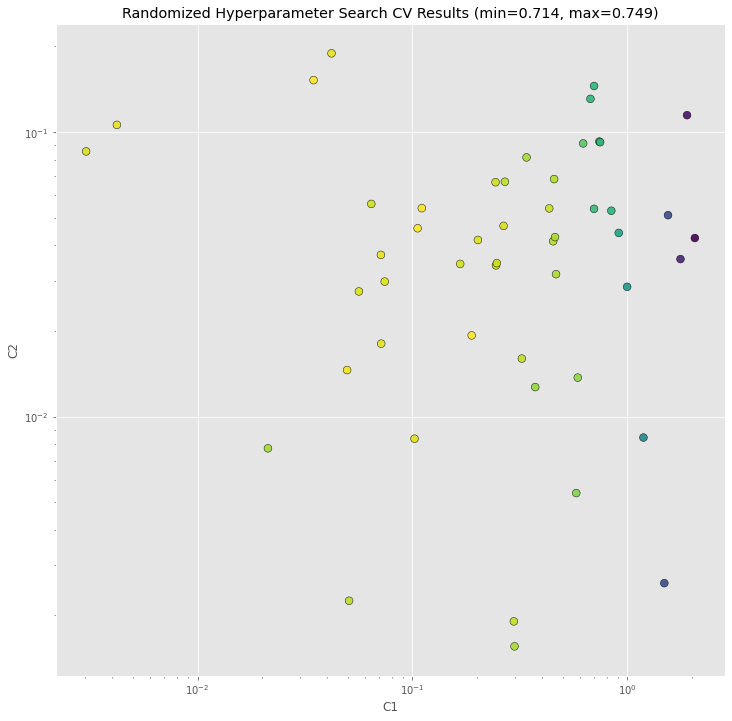

In [33]:
_x = [s['c1'] for s in rs.cv_results_['params']]
_y = [s['c2'] for s in rs.cv_results_['params']]
_c = rs.cv_results_['mean_test_score']

fig = plt.figure()
fig.set_size_inches(12, 12)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_title("Randomized Hyperparameter Search CV Results (min={:0.3}, max={:0.3})".format(
    min(_c), max(_c)
))

ax.scatter(_x, _y, c=_c, s=60, alpha=0.9, edgecolors=[0,0,0])

print("Dark blue => {:0.4}, dark red => {:0.4}".format(min(_c), max(_c)))

## Check best estimator on our test data

As you can see, quality is improved.

In [34]:
crf = rs.best_estimator_
y_pred = crf.predict(X_test)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['B-LOC', 'I-LOC', 'B-MISC', 'I-MISC', 'B-ORG', 'I-ORG', 'B-PER', 'I-PER'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


              precision    recall  f1-score   support

       B-LOC      0.806     0.780     0.793      1084
       I-LOC      0.720     0.625     0.669       325
      B-MISC      0.745     0.552     0.634       339
      I-MISC      0.718     0.576     0.639       557
       B-ORG      0.806     0.836     0.821      1400
       I-ORG      0.847     0.803     0.824      1104
       B-PER      0.847     0.883     0.865       735
       I-PER      0.891     0.943     0.916       634

   micro avg      0.815     0.787     0.801      6178
   macro avg      0.798     0.750     0.770      6178
weighted avg      0.811     0.787     0.797      6178



## Let's check what classifier learned

In [35]:
from collections import Counter

def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))

print("Top likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common(20))

print("\nTop unlikely transitions:")
print_transitions(Counter(crf.transition_features_).most_common()[-20:])

Top likely transitions:
B-ORG  -> I-ORG   7.332829
I-ORG  -> I-ORG   6.987330
B-MISC -> I-MISC  6.738847
I-MISC -> I-MISC  6.536893
B-PER  -> I-PER   6.464758
B-LOC  -> I-LOC   5.570934
I-PER  -> I-PER   5.173898
I-LOC  -> I-LOC   4.833802
O      -> O       3.828644
O      -> B-ORG   2.827675
O      -> B-PER   2.537467
O      -> B-MISC  1.952749
O      -> B-LOC   1.938661
I-PER  -> B-LOC   0.729162
B-ORG  -> O       0.460527
B-LOC  -> B-LOC   0.454089
B-MISC -> B-ORG   0.365817
B-ORG  -> B-LOC   0.318117
B-MISC -> O       -0.033820
B-MISC -> B-LOC   -0.212750

Top unlikely transitions:
B-LOC  -> B-MISC  -1.802258
I-MISC -> I-ORG   -1.812499
B-ORG  -> B-ORG   -1.839612
I-ORG  -> I-PER   -1.889328
I-PER  -> I-LOC   -2.013074
B-PER  -> B-MISC  -2.044271
I-MISC -> B-LOC   -2.123373
I-PER  -> B-ORG   -2.133767
B-ORG  -> B-MISC  -2.148378
I-ORG  -> B-MISC  -2.152028
I-ORG  -> B-LOC   -2.222267
I-ORG  -> I-LOC   -2.321297
I-PER  -> B-MISC  -2.354197
I-MISC -> I-LOC   -2.444865
B-MISC -> B-MIS

We can see that, for example, it is very likely that the beginning of an organization name (B-ORG) will be followed by a token inside organization name (I-ORG), but transitions to I-ORG from tokens with other labels are penalized.

Check the state features:

In [36]:
def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))    

print("Top positive:")
print_state_features(Counter(crf.state_features_).most_common(30))

print("\nTop negative:")
print_state_features(Counter(crf.state_features_).most_common()[-30:])

Top positive:
8.543366 B-ORG    word.lower():efe-cantabria
7.744801 B-ORG    word.lower():psoe-progresistas
5.489655 I-ORG    -1:word.lower():l
4.860263 O        BOS
4.367538 B-ORG    word.lower():telefónica
4.366026 B-MISC   word.lower():justicia
4.354364 B-LOC    word.lower():líbano
4.312683 B-ORG    word[-2:]:-e
4.277570 B-MISC   word.lower():competencia
4.219916 B-LOC    -1:word.lower():cantabria
4.215343 O        word.lower():r.
4.215343 O        word[-3:]:R.
4.191642 B-ORG    word.lower():xfera
4.151865 B-ORG    word.isupper()
4.004479 B-MISC   word.lower():diversia
3.975005 B-PER    -1:word.lower():según
3.879740 O        word.lower():b
3.879740 O        word[-3:]:B
3.879740 O        word[-2:]:B
3.838983 O        bias
3.774954 B-ORG    word.lower():terra
3.720719 B-MISC   word.lower():internet
3.595631 B-LOC    word.lower():estrecho
3.587206 B-MISC   word.lower():exteriores
3.569739 B-ORG    word.lower():ciu
3.566389 B-ORG    word[-3:]:CiU
3.566389 B-ORG    word[-2:]:iU
3.549171



Some observations:

   * **9.385823 B-ORG word.lower():psoe-progresistas** - the model remembered names of some entities - maybe it is overfit, or maybe our features are not adequate, or maybe remembering is indeed helpful;
   * **4.636151 I-LOC -1:word.lower():calle:** "calle" is a street in Spanish; model learns that if a previous word was "calle" then the token is likely a part of location;
   * **-5.632036 O word.isupper()**, **-8.215073 O word.istitle()** : UPPERCASED or TitleCased words are likely entities of some kind;
   * **-2.097561 O postag:NP** - proper nouns (NP is a proper noun in the Spanish tagset) are often entities.

What to do next

    * Load 'testa' Spanish data.
    * Use it to develop better features and to find best model parameters.
    * Apply the model to 'testb' data again.

The model in this notebook is just a starting point; you certainly can do better!

